## Simulation for biallelic dynamics of SCN1A

In [55]:
# The following section only needs to be executed when running off of google drive

# from google.colab import drive
# drive.mount('/content/drive')

# This needs to be run only once at the beginning to access the models
#-------------------------------------------------------------------------------
# !pip3 install --upgrade git+https://github.com/roschkoenig/SodMod.git@Single_Cell_Playground
import sys
!{sys.executable} -m pip install -e '/Volumes/GoogleDrive/My Drive/Research/1906 SCN1A Biallelic Dynamics/02 - Scripts/sodmod'


Obtaining file:///Volumes/GoogleDrive/My%20Drive/Research/1906%20SCN1A%20Biallelic%20Dynamics/02%20-%20Scripts/sodmod
  Attempting uninstall: sodmod
    Found existing installation: sodmod 0.1
    Uninstalling sodmod-0.1:
      Successfully uninstalled sodmod-0.1
  Running setup.py develop for sodmod


In [231]:
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
from scipy.integrate import odeint
# from torch import multiprocessing as mp
import multiprocessing as mp
from itertools import repeat
# from IPython.display import set_matplotlib_formats
# from google.colab import files
import matplotlib as mpl
import pickle
import os

import sodmod as sm
from sodmod import params as pr
from sodmod import cells as cl
from sodmod import incurr as ic
from sodmod import plot as pl

In [268]:
# Manual definitions
#===============================================================================
# Simulations
#-------------------------------------------------------------------------------
np.random.seed(1000)
steps       = 30                          # Number of simulations to be ru
ctyp        = 'PY'                        # Cell type to be used 'IN', 'PY', 'RE'
no_parallel = False 
F           = {'base': '/Volumes/GoogleDrive/My Drive/Research/1906 SCN1A Biallelic Dynamics/02 - Scripts/sodmod'}

# Define parameters for the selected plot type
#-------------------------------------------------------------------------------
class sim_specs:
    def __init__(self, whichplot, itype = 'random'):
        self.name   = whichplot
        self.V0     = -80
        self.conds  = ['WT37', 'AS37', 'TI37']    # Conditions to be modelled
        self.cols   = ['k', 'b', 'r']             # Colours for plotting 
        self.ctyp   = 'PY'

        if whichplot == 'sweep':
            self.ptype      = 'sweep'
            self.paradigm   = 'constant'
            self.T          = np.linspace(0,250,5000)
            self.steps      = 30

        if whichplot == 'bifurcation':
            self.ptype      = 'bifurcation'
            self.paradigm   = 'constant'
            self.T          = np.linspace(0,250,5000)
            self.steps      = 5
            self.Y0         = initials(self.ctyp)

        if whichplot == 'ramp':
            self.ptype      = 'timeseries'
            self.paradigm   = 'ramp'              
            self.T          = np.linspace(0,1000,10000) 

        if whichplot == 'phasespace':
            self.ptype      = 'phasespace'
            self.paradigm   = 'constant'
            self.T          = np.linspace(0, 250, 5000) 
        
    def initialise(self, itype = 'random'):
        if itype == 'random':
            V0 = {}
            for c in self.conds:
                testpar = pr.params(self.conds[0], 0, self.ctyp, self.paradigm,
                                    NaP_scl = 0)
                v0 = np.random.rand(1,len(testpar['snames']))
                v0[0,0] = self.V0
                V0.update({c:v0})
            
        if itype == 'preset_baseline_same':
            V0 = {'WT37':np.array([[-69, 0.01, 0.01, 1.00, 0.24, 0.03]]), 
                  'AS37':np.array([[-69, 0.01, 0.01, 1.00, 0.24, 0.03]]), 
                  'TI37':np.array([[-69, 0.01, 0.01, 1.00, 0.24, 0.03]])}
            
        if itype == 'preset_baseline_types':
            V0 = {'WT37':np.array([[-67.72, 0.017, 0.016, 1.00, 0.03, 0.04]]),
                  'AS37':np.array([[-68.48, 0.015, 0.010, 1.00, 0.02, 0.03]]), 
                  'TI37':np.array([[-56.18, 0.072, 0.083, 0.87, 0.24, 0.08]])}

        self.Y0 = V0
        return self


## Parameter Sweep 
One of the key parameters that differs between mutants and wild types is not included in the standard HH formulations of cortical neurons: the conductance associated with the __persistent sodium current__. In order to identify ranges of this parameter that still allow firing of neurons, we have implemented a parameter sweep. 

For this, we scale the contribution of persistant sodium currents to the overall sodium conductance, whilst preserving relative differences between the HH models of different mutants. For each value of this _scaling parameter_, we then evaluate the range of input currents for which the neurons still fire. 

### Relevant variables in code below

- __`Na_scl`__: scaling parameter that adjusts the relative contribution of the persistent sodium current
- __`I_scl`__: scaling parameter that adjusts the input current for each model run
- __`Vy`__: This is a two dimensional array (of the scale $n*m$, where $n$  is the length of `Na_scl`, and $m$ is the length of `I_scl`) that contains all simulations. Each element of the array is a dictionary, which contains one simulated time series for each condition. 

In [269]:
#-------------------------------------------------------------------------------
# Parameter sweep over different normalisation ranges of NaP
#-------------------------------------------------------------------------------
specs = sim_specs('sweep').initialise('preset_baseline_types')
if specs.name == 'sweep':

    # Define conditions to be tested
    #-----------------------------------------------------------------------------
    I_scl  = np.exp(np.linspace(-6,6,specs.steps))
    Na_scl = np.exp(np.linspace(-3,0,specs.steps))

    Vy = []
    ni = 0
    
    print('Simulating different scaling for the persistent sodium current:')
    for n in Na_scl:
        print('Currently runnning simulation No. ' +str(ni+1)+ '/' +str(len(Na_scl)))
        vy = []
        for i in I_scl:
            if len(vy) == 0: 
                initials = initial_c[ctyp] if ctyp in initial_c.keys() else None
                vy.append(cl.runsim(i, n, specs, specs.Y0)) 
            else: 
                vy.append(cl.runsim(i, n, specs, vy[-1]))
        Vy.append(vy)
        ni = ni + 1

Simulating different scaling for the persistent sodium current:
Currently runnning simulation No. 1/30
Currently runnning simulation No. 2/30
Currently runnning simulation No. 3/30
Currently runnning simulation No. 4/30
Currently runnning simulation No. 5/30
Currently runnning simulation No. 6/30
Currently runnning simulation No. 7/30
Currently runnning simulation No. 8/30
Currently runnning simulation No. 9/30
Currently runnning simulation No. 10/30
Currently runnning simulation No. 11/30
Currently runnning simulation No. 12/30
Currently runnning simulation No. 13/30
Currently runnning simulation No. 14/30
Currently runnning simulation No. 15/30
Currently runnning simulation No. 16/30
Currently runnning simulation No. 17/30
Currently runnning simulation No. 18/30
Currently runnning simulation No. 19/30
Currently runnning simulation No. 20/30
Currently runnning simulation No. 21/30
Currently runnning simulation No. 22/30
Currently runnning simulation No. 23/30
Currently runnning simula

In [229]:
# Optional saving 
#-------------------------------------------------------------------------------------
do_save = False 
if do_save:
    SIM = {'P1': 'Na_scl', 'P1_values': Na_scl,
           'P2': 'I_scl', 'P2_values': I_scl,
           'ctyp': ctyp, 'data': Vy}

    pkl = open(F['base'] +os.sep+ 'simulation_results' +os.sep+ 
               'Parameter_Sweep.pkl','wb')
    pickle.dump(SIM, pkl)

### Parameter sweep plot
Below we plot the results of the parameter sweep: On the left we plot the bifurcation plots with control-parameter `I_scl`, for various values of `Na_scl`. On the left we show the same data, but now showing the two-dimensional map of the two parameters, with each pixel representing the oscillatory amplitude for the particular parameter bin.

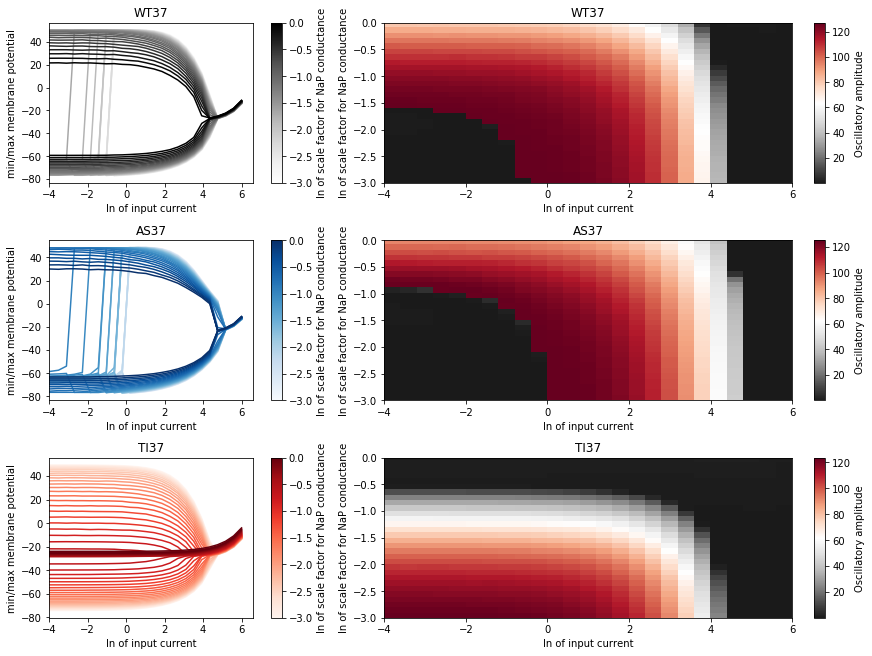

In [270]:
pl.sweep(Vy, I_scl, Na_scl, specs.ctyp, specs.cols, figscale = 1.)

In [267]:
Vy[0][7]['TI37'][-1,:][5]

0.07797405637322768

## Bifurcation analysis
Based on the analysis above, we choose a persistent sodium current value for which all three neuronal classes have at least some firing activity. For these, we rerun the simulation above in finer granularity and both forwards and backwards in order to identify the bifurcation behaviour of each of the neurons

In [ ]:
reload(cl)
#-------------------------------------------------------------------------------
# Bifurcation execution - runs several iteration, forward and backward
#-------------------------------------------------------------------------------
specs = sim_specs('bifurcation')
if specs.name == 'bifurcation':

    # Define conditions to be tested
    #-------------------------------------------------------------------------------
    I_scl = np.exp(np.arange(-2,6,6/steps))      # Input currents to be modelled

    # Looped execution (for bifurcation analysis)
    #-------------------------------------------------------------------------------
    print('Running forward simulation')
    Vy_fwd = []
    I_fwd  = []
    for i in I_scl:
        if len(Vy_fwd) == 0:  Vy_fwd.append(runsim(i, conds, getattr(cl, ctyp), 
                                                   V0, paradigm=paradigm))
        else:                 Vy_fwd.append(runsim(i, conds, getattr(cl, ctyp), 
                                                   V0, Vy_fwd[-1], paradigm=paradigm))
        I_fwd.append(i)
  
    print('Running backward simulation')
    Vy_bwd = []
    I_bwd  = []
    for i in np.flip(I_scl):
        if len(Vy_bwd) == 0:  Vy_bwd.append(runsim(i, conds, getattr(cl, ctyp), 
                                                   V0, paradigm=paradigm))
        else:                 Vy_bwd.append(runsim(i, conds, getattr(cl, ctyp), 
                                                   V0, Vy_bwd[-1], paradigm=paradigm))
        I_bwd.append(i)  

    Vy    = Vy_fwd
    I_scl = I_fwd

In [12]:
################################## Run ODE #####################################

#-------------------------------------------------------------------------------
# Ramp model execution - only executes one time series
#-------------------------------------------------------------------------------
if whichplot == 'ramp':
  Vy       = []
  i_scl    = np.exp(6)     # Run all the way up to maximum value
  Vy.append( runsim(i_scl, conds, getattr(cl, ctyp), V0, paradigm=paradigm) )

#-------------------------------------------------------------------------------
# Phasespace execution - runs only if required - forward only
#-------------------------------------------------------------------------------
if whichplot == 'phasespace':
  # Only actually run estimation of required
  #-----------------------------------------------------------------------------
  if not ('Vy' in locals() and len(Vy) > 1):  # Only run if bifurcation hasn't been run before 
    I_scl  = np.exp(np.arange(-2,6,6/steps))

    if not no_parallel:             # Run on parallel pool if allowed
      p      = mp.Pool(len(I_scl)) 
      Vy     = p.starmap(runsim, zip(I_scl, repeat(conds), repeat(getattr(cl, ctyp)), 
                                     repeat(V0), repeat(None), repeat(paradigm)))

    else:                           # Run in sequence if no parallel 
      Vy = []
      for i in I_scl:
        if len(Vy) == 0:  Vy.append(runsim(i, conds, getattr(cl, ctyp), 
                                           V0, paradigm=paradigm))
        else:             Vy.append(runsim(i, conds, getattr(cl, ctyp), 
                                           V0, Vy[-1], paradigm=paradigm))
  
  else: print('Didn\'t neet to calculate anything')


Simulating different scaling for the persistent sodium current:
Currently runnning simulation for Na_scl = 0.049787068367863944
Currently runnning simulation for Na_scl = 0.06720551273974976
Currently runnning simulation for Na_scl = 0.09071795328941247
Currently runnning simulation for Na_scl = 0.12245642825298185
Currently runnning simulation for Na_scl = 0.16529888822158642
Currently runnning simulation for Na_scl = 0.22313016014842962
Currently runnning simulation for Na_scl = 0.30119421191220175
Currently runnning simulation for Na_scl = 0.4065696597405986
Currently runnning simulation for Na_scl = 0.5488116360940256
Currently runnning simulation for Na_scl = 0.7408182206817167


In [ ]:
# do_save = False
set_matplotlib_formats('svg')
if whichplot == 'ramp': plot_timeseries(Vy, i_scl, ctyp, paradigm=paradigm)
if whichplot == 'bifurcation': plot_bifurcation(Vy_fwd, Vy_bwd, I_fwd, I_bwd, ctyp, direction=[0,1])
if whichplot == 'phasespace': plot_phasespace(Vy, I_scl, ctyp, ['m_Na', 'h_Na'], Nplots = 50)

if do_save:
  plt.savefig(whichplot+'.pdf')
  files.download(whichplot+'.pdf')


In [235]:
specs.Y0

{'WT37': array([[-6.9e+01,  1.0e-02,  1.0e-02,  1.0e+00,  2.4e-01,  3.0e-02]]),
 'AS37': array([[-6.9e+01,  1.0e-02,  1.0e-02,  1.0e+00,  2.4e-01,  3.0e-02]]),
 'TI37': array([[-6.9e+01,  1.0e-02,  1.0e-02,  1.0e+00,  2.4e-01,  3.0e-02]])}

In [75]:
[k for k in Vy[0][0].keys()]

['WT37', 'AS37', 'TI37']

In [122]:
F['base']

'/Volumes/GoogleDrive/My Drive/Research/1906 SCN1A Biallelic Dynamics/02 - Scripts/sodmod/'